In [1]:
import pathlib

import hubbardml
from hubbardml import keys, plots, similarities
import numpy as np
import torch

hubbardml.utils.random_seed()

dtype = torch.float32
torch.set_default_dtype(dtype)
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
device, torch.get_default_dtype()

/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


('cpu', torch.float32)

In [2]:
VALIDATE_PERCENTAGE = 0.2
DATASET = "../data/data_uv_unique_inout_2023_2_8.json"

SAVEFIGS = False
TARGET_PARAM = 'U'
DELTA_LEARNING = False


def plotfile(label: str):
    return f'plots/{DATASET}_{label}.pdf'

In [3]:
df = hubbardml.datasets.load(DATASET)

## Input creation

Filter the DF to keep things we want

In [4]:
species = list(df[keys.ATOM_1_ELEMENT].unique())
species = ("Mn", "Fe", "Ni")
graph = hubbardml.graphs.UGraph(species)

df = graph.prepare_dataset(df)
print(len(df))

df = graph.identify_duplicates(df)
len(df[df[keys.TRAINING_LABEL] == keys.DUPLICATE])

/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


414


/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


165

In [5]:
# similarity_frame[(similarity_frame["input_dist"] < 1e-3) & (similarity_frame["delta_param"] < 1e-3)]

## Model creation

In [6]:
model = hubbardml.models.UModel(
    graph,
    feature_irreps="4x0e + 4x1e + 4x2e",
    hidden_layers=2,
    rescaler=hubbardml.models.Rescaler.from_data(df[keys.PARAM_OUT], method="mean"),
    irrep_normalization="component",
)
model.to(dtype=dtype, device=device)

/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


UModel(
  (layers): ModuleList(
    (0): TensorSquare(4x0e+1x2e+1x4e+2x0e+1x2e+1x4e+1x0e+1x2e+1x4e+1x6e+1x8e+1x0e -> 12x0e+4x1e+4x2e | 828 paths | 828 weights)
    (1): Gate (12x0e+4x1e+4x2e -> 4x0e+4x1e+4x2e)
    (2): TensorSquare(4x0e+4x1e+4x2e -> 12x0e+4x1e+4x2e | 744 paths | 744 weights)
    (3): Gate (12x0e+4x1e+4x2e -> 4x0e+4x1e+4x2e)
    (4): TensorSquare(4x0e+4x1e+4x2e -> 1x0e | 30 paths | 30 weights)
    (5): Rescaler()
  )
)

## Split test/train

In [7]:
hubbardml.datasets.split(df, method='category', frac=0.2, category=["species"])

,dir,material,is_vdw,uv_iter,formula,cell,n_atoms_uc,person,structure_index,pw_time_unix,...,atom_2_frac_coords,atom_2_starting_mag,atom_2_final_mag,param_delta,species,label,colour,sc_paths,cluster_id,training_label
0,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,"[0.0, 0.0, 0.0]",0.0,0.0000,10.2709,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,3a18eb26-2cb3-4999-bc13-ef597ffbc9fd,train
78,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,"[0.25, 0.5, 0.0]",1.0,0.7291,9.6452,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,6c4b5c09-bd16-4997-b10c-dd94d7c3f155,duplicate
118,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,"[0.75, 0.5, 0.0]",1.0,-0.7291,9.6452,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,6c4b5c09-bd16-4997-b10c-dd94d7c3f155,duplicate
161,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,"[0.0, 0.0, 0.25]",1.0,0.7290,9.6452,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,6c4b5c09-bd16-4997-b10c-dd94d7c3f155,validate
197,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,"[0.5, 0.0, 0.25]",1.0,-0.7291,9.6452,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,6c4b5c09-bd16-4997-b10c-dd94d7c3f155,duplicate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103310,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,3,,"[15.4309, 0.0, 0.0, 0.0, 15.430421642099999, 0...",48,iurii,122,1.638445e+09,...,"[0.4997503, 0.7502467, 0.7494582]",0.0,2.9014,-0.0015,(Mn),Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,e6e4f8cf-5e75-476c-acb4-7e2864b7abee,duplicate
103986,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,3,,"[15.4309, 0.0, 0.0, 0.0, 15.430421642099999, 0...",48,iurii,122,1.638445e+09,...,"[0.0, 0.0, 0.5]",0.0,-2.9633,-0.0016,(Mn),Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,36b5f0cc-5af7-44d0-bd13-b68d94126c3b,duplicate
104259,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,3,,"[15.4309, 0.0, 0.0, 0.0, 15.430421642099999, 0...",48,iurii,122,1.638445e+09,...,"[0.25, 0.25, 0.5]",0.0,-2.9633,-0.0016,(Mn),Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,c6f50c81-5555-4197-aeeb-2b8d1b8da4e0,train
104557,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,3,,"[15.4309, 0.0, 0.0, 0.0, 15.430421642099999, 0...",48,iurii,122,1.638445e+09,...,"[0.5, 0.0, 0.0]",0.0,2.9633,-0.0016,(Mn),Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,c6f50c81-5555-4197-aeeb-2b8d1b8da4e0,duplicate


In [8]:
df.loc[df[keys.TRAINING_LABEL] == keys.DUPLICATE, keys.TRAINING_LABEL] = keys.TRAIN

In [9]:
# Get the indices of the training and validation data
train_idx = df[df[keys.TRAINING_LABEL] == keys.TRAIN].index
validate_idx = df[df[keys.TRAINING_LABEL] == keys.VALIDATE].index

print(df.loc[train_idx][keys.ATOM_1_ELEMENT].value_counts())
print(df.loc[validate_idx][keys.ATOM_1_ELEMENT].value_counts())

Ni    167
Mn    133
Fe     65
Name: atom_1_element, dtype: int64
Mn    22
Ni    14
Fe    13
Name: atom_1_element, dtype: int64


In [10]:
trainer = hubbardml.Trainer.from_frame(
    model=model,
    opt=torch.optim.Adam(model.parameters(), lr=0.01),
    loss_fn=torch.nn.MSELoss(),
    frame=df,
    target_column=keys.PARAM_DELTA if DELTA_LEARNING else keys.PARAM_OUT,
)

In [25]:
trainer.overfitting_window = 400

trainer.train(
    callback=lambda trainer: print(trainer.status()),
    callback_period=50,
    max_epochs=2_000,
)

epoch: 4000 train: mse 0.08338, valid: mse 0.17543 rmse 0.4188
epoch: 4050 train: mse 0.08234, valid: mse 0.17429 rmse 0.4175
epoch: 4100 train: mse 0.08367, valid: mse 0.17545 rmse 0.4189
epoch: 4150 train: mse 0.08241, valid: mse 0.17425 rmse 0.4174
epoch: 4200 train: mse 0.08187, valid: mse 0.17386 rmse 0.4170
epoch: 4250 train: mse 0.08178, valid: mse 0.17400 rmse 0.4171
epoch: 4300 train: mse 0.08276, valid: mse 0.17446 rmse 0.4177
epoch: 4350 train: mse 0.08150, valid: mse 0.17400 rmse 0.4171
epoch: 4400 train: mse 0.08136, valid: mse 0.17412 rmse 0.4173
epoch: 4450 train: mse 0.08286, valid: mse 0.17624 rmse 0.4198
epoch: 4500 train: mse 0.08122, valid: mse 0.17413 rmse 0.4173
epoch: 4550 train: mse 0.08106, valid: mse 0.17424 rmse 0.4174
epoch: 4600 train: mse 0.10287, valid: mse 0.17738 rmse 0.4212
epoch: 4650 train: mse 0.08159, valid: mse 0.17427 rmse 0.4175
epoch: 4700 train: mse 0.08079, valid: mse 0.17431 rmse 0.4175
epoch: 4750 train: mse 0.08067, valid: mse 0.17443 rmse

'max_epochs'

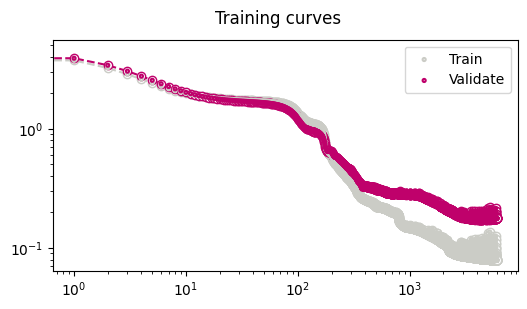

In [26]:
fig = trainer.plot_training_curves();
if SAVEFIGS:
    fig.savefig(plotfile('+U_training'), bbox_inches='tight')
fig.gca().set_xscale("log")

In [27]:
with torch.no_grad():
    train_predicted = hubbardml.engines.evaluate(model, trainer.train_loader).detach().cpu().numpy().reshape(-1)
    val_predicted = hubbardml.engines.evaluate(model, trainer.validate_loader).detach().cpu().numpy().reshape(-1)

df.loc[validate_idx, keys.PARAM_OUT_PREDICTED] = val_predicted
df.loc[train_idx, keys.PARAM_OUT_PREDICTED] = train_predicted

if DELTA_LEARNING:
    df[keys.PARAM_OUT_PREDICTED] += df[keys.PARAM_IN]

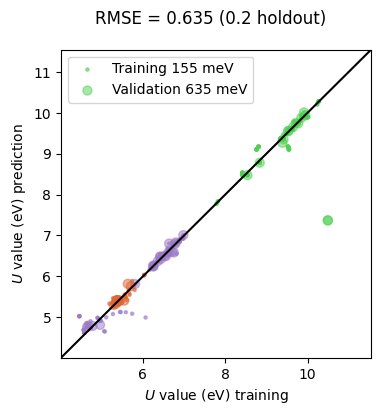

In [28]:
def rmse(y1, y2):
    return np.sqrt(((y1 - y2) ** 2).mean())


df_validate = df.loc[validate_idx]
validate_rmse = hubbardml.datasets.rmse(df_validate)
plots.create_parity_plot(df, title=f'RMSE = {validate_rmse:.3f} ({VALIDATE_PERCENTAGE} holdout)',
                         axis_label=f'${TARGET_PARAM}$ value (eV)');

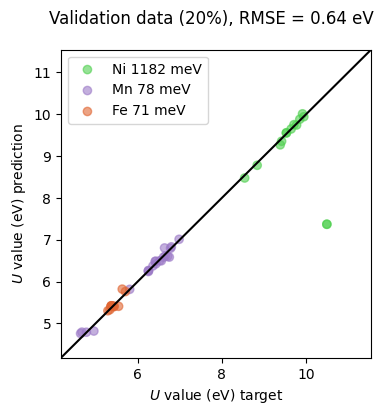

In [29]:
fig = plots.split_plot(df_validate, keys.ATOM_1_ELEMENT,
                       axis_label='$U$ value (eV)',
                       title=f'Validation data ({VALIDATE_PERCENTAGE * 100:.0f}%), RMSE = {validate_rmse:.2f} eV');

if SAVEFIGS:
    fig.savefig(plotfile('+U_parity_species'), bbox_inches='tight')

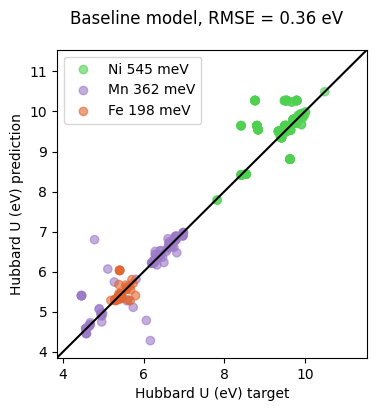

In [30]:
df_ref = df.copy()
df_ref[keys.PARAM_OUT_PREDICTED] = df_ref[keys.PARAM_IN]
df_ref = df_ref[~(df_ref[keys.UV_ITER] == 1)]
fig = plots.split_plot(df_ref, keys.ATOM_1_ELEMENT, axis_label=f'Hubbard {TARGET_PARAM} (eV)',
                       title=f'Baseline model, RMSE = {hubbardml.datasets.rmse(df_ref):.2f} eV');

if SAVEFIGS:
    fig.savefig(plotfile('U_parity_species_ref'), bbox_inches='tight')

In [31]:
df_ref = df.copy()
df_ref[keys.PARAM_OUT_PREDICTED] = df_ref[keys.PARAM_IN]
df_ref = df_ref[~(df_ref[keys.UV_ITER] == 1)]
fig = plots.split_plot(
    df_ref,
    keys.ATOM_1_ELEMENT,
    axis_label=f'Hubbard {TARGET_PARAM} (eV)',
    title=f'Baseline model, RMSE = {hubbardml.datasets.rmse(df_ref, label="both"):.2f} eV',
);

if SAVEFIGS:
    fig.savefig(plotfile('U_parity_species_ref'), bbox_inches='tight')

TypeError: rmse() got an unexpected keyword argument 'label'

In [ ]:
{str(pathlib.Path(directory).parent) for directory in df[keys.DIR].unique()}

In [ ]:
max_range = df[keys.PARAM_OUT].max() - df[keys.PARAM_OUT].min()
max_range = max(max_range, (df[keys.PARAM_OUT_PREDICTED].max() - df[keys.PARAM_OUT_PREDICTED].min()))
print(max_range)

plots.create_progression_plots(
    df,
    '/home/azadoks/Projects/uv_ml/data/iurii/Olivines/LiMnPO4/B2_Li0.25MnPO4/DFT_plus_UV',
    yrange=1.2
);

In [ ]:
if SAVEFIGS:
    idx = 0
    for figgroup in res:
        for fig in figgroup.values():
            fig.savefig(f'plots/hubbard_u/steps_{idx}_+U.pdf', bbox_inches='tight')
            idx += 1

In [ ]:
import copy

fig, ax = copy.deepcopy(model.tp1).cpu().visualize()
# ax.get_lines()[0].set_color('black')
for patch in ax.patches:
    patch.set_color(plots.plot_colours[2])

if SAVEFIGS:
    fig.savefig('plots/hubbard_u_tp.pdf', bbox_inches='tight')

In [ ]:
df[df[keys.PARAM_IN] == 0.][keys.TRAINING_LABEL]
